# Generation of System model (single situation)
## Load data

Loading data from pickle files. Each file corresponds to a CrowdNav situation. 

For each situation, 1000 values of the trip overhead are provided for each of the 2^7 = 128 configurations of the full factorial design with 7 factors (the CrowdNav parameters) and 2 levels per factor (min and max values of each parameter). 

There are data from 3 situations:
* 0 regular cars, 750 smart cars
* 400 regular cars, 350 smart cars
* 0 regular cars, 350 smart cars

___You can change the name of the index in the following script to load data from other situations.___

In [2]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from factorial_anova_analysis import get_data_and_knobs

strategy_knobs = {
    "route_random_sigma": ([0.0, 0.3], 0.3),
    "exploration_percentage": ([0.0, 0.3], 0.3),
    "max_speed_and_length_factor": ([1.0, 2.5], 1.5),
    "average_edge_duration_factor": ([1.0, 2.5], 1.5),
    "freshness_update_factor": ([5, 20], 15),
    "freshness_cut_off_value": ([100, 700], 600),
    "re_route_every_ticks": ([10, 70], 60),
}

index = "full_factorial-0_regular_cars-750_smart_cars"     
# index = "full_factorial-400_regular_cars-350_smart_cars"     
# index = "full_factorial-0_regular_cars-350_smart_cars"     

all_data, all_knobs, exp_count = get_data_and_knobs(index, strategy_knobs, False)
total_sample_size_per_conf = 1000
print "Configurations: " + str(exp_count)
if len(all_data[0]) == total_sample_size_per_conf:
    print "1000 values in first configuration, continue!"

data retrieved from file full_factorial-0_regular_cars-750_smart_cars.pickle
~~~~~~~~~
full_factorial-0_regular_cars-750_smart_cars
~~~~~~~~~
Configurations: 128
1000 values in first configuration, continue!


## Factorial ANOVA with variable sample sizes

Here, we randomly sample from the 1000 values per confuiguration and apply factorial ANOVA to the result. 

We increase the size of the sample (by a step of 20) until we reach an ANOVA result where more than 5 effects have 
* alpha < 0.005
* effect size (measured by omega squared metric) > 0.001

In [3]:
from analysis_lib.factorial_tests import FactorialAnova
import random

min_effect_size = 0.001
alpha = 0.0005

fake_id = "123456"
y_key = 'overhead'

for sample_size in range(20, 1001, 20):
    print "--------"
    print "Sample size: " + str(sample_size)

    random.seed(123456) 
    
    inds = {}
    for k in all_data.keys():
        inds[k] = random.sample(range(total_sample_size_per_conf), sample_size)

    analysis_data = {}
    for k in all_data.keys(): 
        analysis_data[k] = [all_data[k][i] for i in inds[k]]

    analysis_knobs = {}
    for k in all_knobs.keys(): 
        analysis_knobs[k] = [all_knobs[k][i] for i in inds[k]]

    aov_table = FactorialAnova(fake_id, y_key, strategy_knobs.keys(), exp_count).start(analysis_data, analysis_knobs)
    
    aov_table = aov_table.sort_values(by='PR(>F)', ascending=True)
    aov_table = aov_table[aov_table["PR(>F)"] < alpha]
    aov_table = aov_table[aov_table["omega_sq"] > min_effect_size]

    probabilities = aov_table["PR(>F)"]
    omega_sqs = aov_table["omega_sq"]

    print str(len(probabilities)) + " interaction were significant."

    if len(probabilities) >= 5:
        print "Sample size: " + str(sample_size)
        print "============="
        print "...stopping here since we found more than 5 significant interactions."
        print probabilities
        print "**********"
        print omega_sqs       
        print "============="
        break


--------
Sample size: 20
0 interaction were significant.
--------
Sample size: 40
0 interaction were significant.
--------
Sample size: 60
0 interaction were significant.
--------
Sample size: 80
2 interaction were significant.
--------
Sample size: 100
0 interaction were significant.
--------
Sample size: 120
5 interaction were significant.
Sample size: 120
...stopping here since we found more than 5 significant interactions.
C(freshness_cut_off_value):C(exploration_percentage)                                   0.000002
C(re_route_every_ticks)                                                                0.000004
C(freshness_cut_off_value):C(max_speed_and_length_factor):C(exploration_percentage)    0.000007
C(freshness_update_factor)                                                             0.000012
C(max_speed_and_length_factor):C(freshness_update_factor)                              0.000016
Name: PR(>F), dtype: float64
**********
C(freshness_cut_off_value):C(exploration_percenta

## ANOVA main effects plots

The main effects of the factorial ANOVA applied in the last step are plotted in line charts. 

Printing statistics...
Factor: route_random_sigma
Level 0:	7680 data points
Level 0.3:	7680 data points
Factor: exploration_percentage
Level 0:	7680 data points
Level 0.3:	7680 data points
Factor: max_speed_and_length_factor
Level 1:	7680 data points
Level 2.5:	7680 data points
Factor: average_edge_duration_factor
Level 1:	7680 data points
Level 2.5:	7680 data points
Factor: freshness_update_factor
Level 5:	7680 data points
Level 20:	7680 data points
Factor: freshness_cut_off_value
Level 100:	7680 data points
Level 700:	7680 data points
Factor: re_route_every_ticks
Level 10:	7680 data points
Level 70:	7680 data points


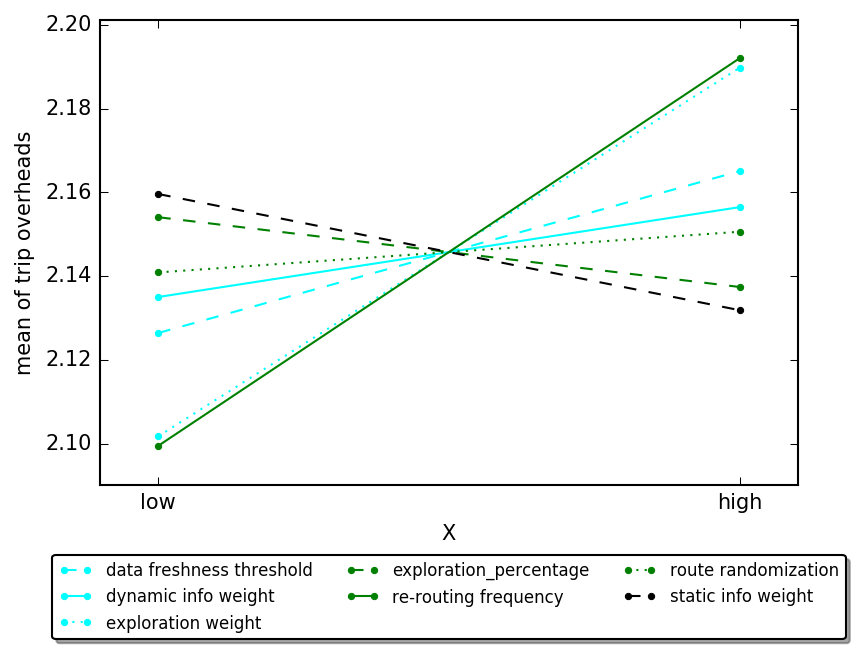

In [11]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

def get_id_for_knob(knob):
    if knob == "route_random_sigma":
        return "route randomization"
    if knob == "exploration_percentage":
        return "exploration_percentage"
    if knob == "max_speed_and_length_factor":
        return "static info weight"
    if knob == "average_edge_duration_factor":
        return "dynamic info weight"
    if knob == "freshness_update_factor":
        return "exploration weight"
    if knob == "freshness_cut_off_value":
        return "data freshness threshold"
    if knob == "re_route_every_ticks":
        return "re-routing frequency"
    
def get_normalized_list(knob_list):
    l = []
    for knob_v in knob_list: 
        if knob_v == 0:
            l.append(0)
        if knob_v == 1:
            l.append(0)
        if knob_v == 5:
            l.append(0)
        if knob_v == 10:
            l.append(0)
        if knob_v == 100:
            l.append(0)
        if knob_v == 0.3:
            l.append(1)
        if knob_v == 2.5:
            l.append(1)
        if knob_v == 20:
            l.append(1)
        if knob_v == 70:
            l.append(1)
        if knob_v == 700:
            l.append(1)
    return l
   
print "Printing statistics..."

knob_names = [
    "route_random_sigma",
    "exploration_percentage",
    "max_speed_and_length_factor",
    "average_edge_duration_factor",
    "freshness_update_factor",
    "freshness_cut_off_value",
    "re_route_every_ticks",
]

knob_values = [
    [0, 0.3],     # route_random_sigma
    [0, 0.3],     # exploration_percentage
    [1, 2.5],     # max_speed_and_length_factor
    [1, 2.5],     # average_edge_duration_factor
    [5, 20],      # freshness_update_factor
    [100, 700],   # freshness_cut_off_value
    [10, 70]      # re_route_every_ticks"
]

knobs = {}
data = {}

for j in range(len(knob_names)): 
    knob_name = knob_names[j]
    print "Factor: " + knob_name 
    for i in knob_values[j]:    
        ind = knob_name + ":" + str(i)
        knobs[ind] = []
        data[ind] = []
        for knob_ind in range(len(analysis_knobs)):
            if analysis_knobs[knob_ind][0].get(knob_name)==i:
                knobs[ind] += [i for k in analysis_knobs[knob_ind]]       
                data[ind] += analysis_data[knob_ind]
        print "Level " + str(i)+":\t" + str(len(data[ind])) + " data points"
    print "========="
    
all_knobs = []
for knob_list in knobs.values():
    all_knobs += get_normalized_list(knob_list)

all_traces = []
for k in knobs.keys():
    all_traces += [get_id_for_knob(k.split(":")[0]) for i in range(len(knobs[k]))]

all_data = []
for data_list in data.values():
    all_data += [d["overhead"] for d in data_list]

fig = interaction_plot(all_knobs, all_traces, all_data,
                       linestyles=['--',  '-', ':',  '--',  '-',':', '--',],
                      colors=['cyan', 'cyan', 'cyan', 'green', 'green', 'green', 'black'])
legend = plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=3, fancybox=True, shadow=True, prop={'size': 8})
plt.ylabel('mean of trip overheads')
plt.xticks([0,1], ["low", "high"])
plt.show()